In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
import sys
sys.path.append('..')

In [3]:
# with open('../models/vspyct_reduced_v1.pcl', 'rb') as f:
#   vspyct = pickle.load(f)
# with open('../models/spyct_reduced_v1.pcl', 'rb') as f:
#   spyct = pickle.load(f)

In [4]:
from src.data.dataset import ReducedDataset

path = os.path.join('../data/raw')
filename = 'BO_truncated_mso_2018.pcl'
data = ReducedDataset(path, filename)
rsf = data.rsf_dataset(to_pcl=False)
X_train, T_train, E_train, X_test, T_test, E_test = data.rsf_split(to_pcl=False)

In [5]:
import torch

X_train, T_train, E_train, X_test, T_test, E_test = torch.tensor(np.vstack(X_train.values).astype('float32')), torch.tensor(T_train), E_train, torch.Tensor(np.vstack(X_test.values).astype('float32')), torch.tensor(T_test), E_test
print(X_train.shape, T_train.shape)

target_spyct_train = np.zeros((X_train.shape[0],350))
for key, value in enumerate(T_train.tolist()):
    for i in range(350):
        # if(E_train[key]==1):
        #     target_spyct_train[key][i] = np.nan
        if(i<value):
            target_spyct_train[key][i] = 1
        else:
            target_spyct_train[key][i] = 0

target_spyct_test = np.zeros((X_test.shape[0],350))
for key, value in enumerate(T_test.tolist()):
    for i in range(350):
        # if(E_test[key]==1):
        #     target_spyct_test[key][i] = np.nan
        if(i<value):
            target_spyct_test[key][i] = 1
        else:
            target_spyct_test[key][i] = 0


target_spyct_train = torch.Tensor(target_spyct_train)
target_spyct_test = torch.Tensor(target_spyct_test)

torch.Size([400, 133]) torch.Size([400])


In [6]:
import spyct
model_spyct = spyct.Model()
model_spyct.fit(X_train.numpy(), target_spyct_train.numpy())
preds_model = model_spyct.predict(X_test.numpy())
print('Finished with original SPYCT')

Finished with original SPYCT


In [97]:
preds_spyct = spyct.predict(X_test.numpy())

In [98]:
X_test.shape

torch.Size([993, 198])

In [ ]:
from src.models import model

bayes_spyct = model.VSpyct(bs=64, max_depth=3)
print('Training variational SPYCT...')
bayes_spyct.fit(X_train, target_spyct_train)
print('Predicting...')
preds_bayes = bayes_spyct.predict(X_test)

In [11]:
preds_bayes_mean = preds_bayes.mean(axis=1)

In [117]:
preds_bayes.shape, preds_bayes_mean.shape

(torch.Size([100, 30, 350]), torch.Size([100, 350]))

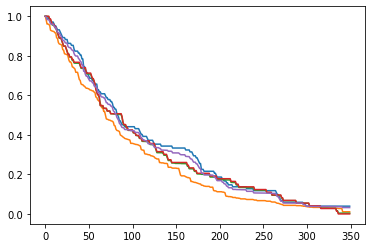

In [100]:
# i=10
for i in range(5):
  plt.plot(preds_bayes_mean[i, :]);

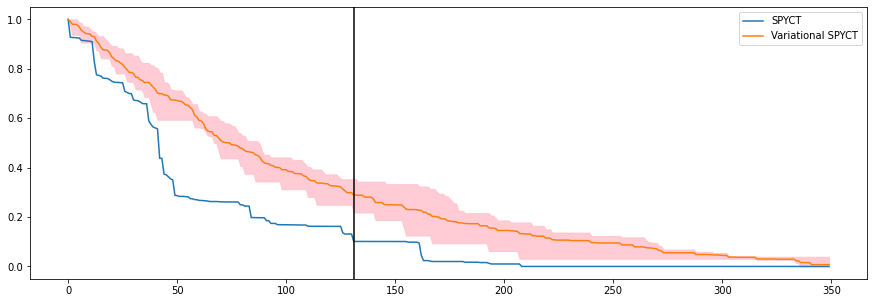

In [133]:
i = 10
plt.figure(figsize=(15,5))
plt.plot(preds_model[i, :], label='SPYCT')
plt.plot(preds_bayes[i, :, :].mean(axis=0), label='Variational SPYCT')

percentiles_10 = torch.quantile(preds_bayes[i, :, :], 0.1, axis=0)
percentiles_90 = torch.quantile(preds_bayes[i, :, :], 0.9, axis=0)

plt.fill_between(range(preds_bayes.shape[-1]), percentiles_10, percentiles_90, color='pink', alpha=0.8)

plt.axvline(sum(target_spyct_test[i].numpy()), color='black')

plt.legend()

In [36]:
preds_bayes_numpy = preds_bayes_mean.numpy()

In [38]:
preds_bayes_numpy.shape, preds_model.shape

((100, 350), (100, 350))

In [61]:
import properscoring as ps

calculate_bs = lambda x: np.nanmean(ps.brier_score(x[1], x[0]), axis=0)

In [64]:
bs_bayes = calculate_bs((preds_bayes_numpy, target_spyct_test))
bs_spyct = calculate_bs((preds_model, target_spyct_test))

In [45]:
bs_spyct = ps.brier_score(target_spyct_test, preds_model)
bs_spyct = np.nanmean(bs_spyct, axis=0)

In [134]:
preds_bayes_10 = torch.quantile(preds_bayes[:, :, :], 0.1, axis=1)
preds_bayes_90 = torch.quantile(preds_bayes[:, :, :], 0.9, axis=1)

bs_bayes_10 = calculate_bs((preds_bayes_10.numpy(), target_spyct_test))
bs_bayes_90 = calculate_bs((preds_bayes_90.numpy(), target_spyct_test))

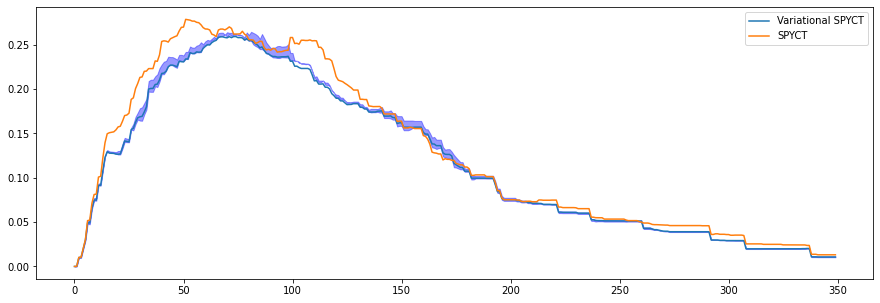

In [160]:
plt.figure(figsize=(15,5))
plt.plot(bs_bayes, label = 'Variational SPYCT')
plt.plot(bs_spyct, label = 'SPYCT')
plt.legend()

plt.fill_between(range(preds_bayes.shape[-1]), bs_bayes_10, bs_bayes_90, color='blue', alpha=0.4)

In [78]:
model_spyct.num_trees

100

In [107]:
model_spyct.trees

[array([<spyct.node.Node object at 0x7fc8755f3be0>,
        <spyct.node.Node object at 0x7fc8762b8230>], dtype=object),
 array([<spyct.node.Node object at 0x7fc8762b8420>,
        <spyct.node.Node object at 0x7fc876060be0>], dtype=object),
 array([<spyct.node.Node object at 0x7fc876060dd0>,
        <spyct.node.Node object at 0x7fc89057c9f0>], dtype=object),
 array([<spyct.node.Node object at 0x7fc89057cbe0>,
        <spyct.node.Node object at 0x7fc8a2b20040>], dtype=object),
 array([<spyct.node.Node object at 0x7fc8a2b20230>,
        <spyct.node.Node object at 0x7fc8a2b4d9f0>], dtype=object),
 array([<spyct.node.Node object at 0x7fc8a2b4dbe0>,
        <spyct.node.Node object at 0x7fc8905cabe0>], dtype=object),
 array([<spyct.node.Node object at 0x7fc8905cadd0>,
        <spyct.node.Node object at 0x7fc8a2ad9dd0>], dtype=object),
 array([<spyct.node.Node object at 0x7fc8a2ad8040>,
        <spyct.node.Node object at 0x7fc876211420>], dtype=object),
 array([<spyct.node.Node object at 0x7fc

In [150]:
bayes_spyct.root_node.split_model.weight

tensor([[-0.7652,  0.4053, -0.6727, -2.3411,  0.4811,  0.6509, -0.0844, -0.4770,
          0.7585,  0.9081, -0.9548,  1.2025,  0.0332, -0.4787,  0.8515,  0.6048,
         -0.2500,  0.5240,  0.0406,  0.0835, -0.5882,  0.5378, -0.0992,  0.9649,
          1.5988, -0.0195, -0.0387, -1.1983,  0.4156, -1.3260, -0.4958,  1.1549,
          0.8777,  1.3902,  0.4990, -0.5536,  0.6889,  1.7614,  0.4235,  0.7691,
          0.6623,  2.0050, -0.6161,  1.6799,  0.1327, -0.2160, -0.5277, -0.4770,
         -0.5666,  0.1922, -2.1902,  0.4578, -0.7012, -1.2958,  0.2900,  0.2423,
          0.0808, -1.0803,  0.3202,  1.0166, -1.5088, -1.5740,  1.0945, -0.5633,
          0.4435,  2.0480, -1.3473, -0.0627, -0.6811, -0.7699,  1.5582, -0.5410,
          1.5278,  1.0054,  0.8438,  0.5275,  0.3274,  1.5081, -1.0298,  0.9221,
          0.4113, -0.8938,  0.9848, -0.2840, -1.4311,  0.9218,  0.8249, -0.6312,
          1.1958, -0.5539,  0.4011,  1.4759, -0.4389,  0.4566, -0.3134,  0.1560,
          0.1441, -0.1360, -